In [21]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from glob import glob
from scipy.interpolate import interp1d
from astropy import units as u
from astropy import constants as con

In [4]:
kep = np.loadtxt('../../Filters/Kepler/Kepler.dat')
pg = np.loadtxt('../../Filters/PANSTARRS/PAN-STARRS_PS1_g.dat')
pr = np.loadtxt('../../Filters/PANSTARRS/PAN-STARRS_PS1_r.dat')
pi = np.loadtxt('../../Filters/PANSTARRS/PAN-STARRS_PS1_i.dat')
pz = np.loadtxt('../../Filters/PANSTARRS/PAN-STARRS_PS1_z.dat')


<IPython.core.display.Javascript object>


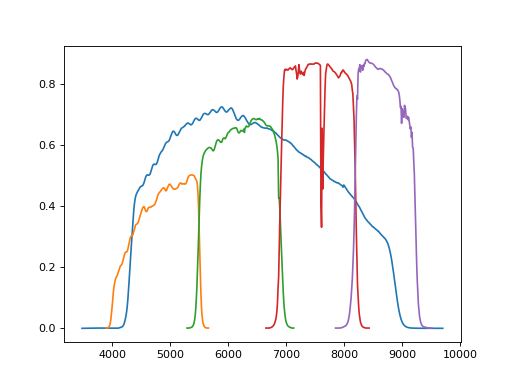

In [9]:
plt.figure()
plt.plot(kep[:,0],kep[:,1])
plt.plot(pg[:,0],pg[:,1])
plt.plot(pr[:,0],pr[:,1])
plt.plot(pi[:,0],pi[:,1])
plt.plot(pz[:,0],pz[:,1])

## stellar library

In [469]:
spec_files = glob('stellar_spec/Pickle/uk*.dat')

In [13]:
synth = pd.DataFrame([])

In [16]:
for file in spec_files:
    

In [65]:
a = 1*u.AA / (2*u.mm)

In [67]:
a.

<function Quantity.compress>

In [80]:
from svo_filters import svo

In [212]:
filters = ['Kepler.K', 'PS1.g', 'PS1.r', 'PS1.i', 'PS1.z', 'PS1.y']

In [468]:
def Synthmag(Spec,Filter):
    spec = np.loadtxt(Spec)
    svo_info = svo.Filter(Filter)
    filt = svo_info.rsr[0]
    width = svo_info.width_eff.to(u.AA)
    lam_eff = svo_info.wave_eff.to(u.AA)
    f_lam = (filt[0,:]* u.micrometer).to(u.AA)
    func = interp1d(f_lam,filt[1,:],bounds_error=False,fill_value=0)
    int_filt = func(spec[:,0])
    
    through = int_filt * spec[:,1] * u.erg/u.s/u.cm**2
    f_lam = np.trapz(through,x=spec[:,0]) / width
    f_nu = f_lam * (lam_eff**2 / con.c.to(u.AA * u.Hz))
    if 'Kepler' in Filter:
        mag = -2.5*np.log10(f_nu.value) - 48.6
    else:
        zp =svo_info.zp* (lam_eff**2 / con.c.to(u.AA * u.Hz))
        zp = -2.5*np.log10(zp.value)
        mag = -2.5*np.log10(f_nu.value) - zp
    return mag

In [460]:
synth = pd.DataFrame(columns=['Kepler_k','PS1_g','PS1_r','PS1_i','PS1_z','PS1_y'])
synth['Spec_type'] = spec_files
synth = synth[['Spec_type','Kepler_k','PS1_g','PS1_r','PS1_i','PS1_z','PS1_y']]
#arr = np.zeros((len(spec_files),len(filters)+1),dtype='object')
for i in range(len(spec_files)):
    mags = np.zeros(len(filters)+1,dtype='object')
    model = spec_files[i].split('/')[-1].split('.')[0]
    mags[0] = model
    for j in range(len(filters)):
        mags[j+1] = Synthmag(spec_files[i],filters[j])
    synth.iloc[i] = mags
    #arr[i,:] = mags

In [215]:
synth.to_csv('Synthetic_pickle_mags.csv')

<IPython.core.display.Javascript object>


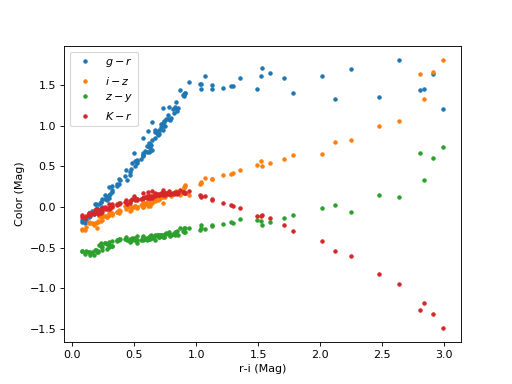

In [461]:
grs = synth['PS1_g']-synth['PS1_r']
plt.figure()
plt.plot(ris,synth['PS1_g']-synth['PS1_r'],'.',label='$g-r$')
plt.plot(ris,synth['PS1_i']-synth['PS1_z'],'.',label='$i-z$')
plt.plot(ris,synth['PS1_z']-synth['PS1_y'],'.',label='$z-y$')
plt.plot(ris,synth['Kepler_k']-synth['PS1_r'],'.',label='$K-r$')

plt.ylabel('Color (Mag)')
plt.xlabel('r-i (Mag)')
plt.legend()

In [428]:
ps1 = pd.read_csv('K2_all_PS1_psc.csv')
ind = np.where(ps1['ps_score'].values > 0.999)[0]
ps1 = ps1.iloc[ind]
print(len(ps1))

39164


<IPython.core.display.Javascript object>


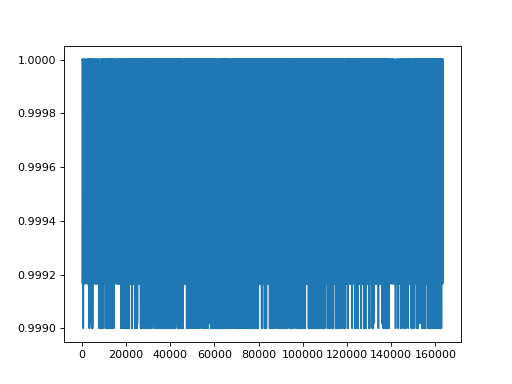

In [429]:
plt.figure()
plt.plot(ps1['ps_score'])

In [444]:

ri = ps1['rMeanPSFMag'] - ps1['iMeanPSFMag']
gr = ps1['gMeanPSFMag'] - ps1['rMeanPSFMag']
iz = ps1['iMeanPSFMag'] - ps1['zMeanPSFMag']
zy = ps1['zMeanPSFMag'] - ps1['yMeanPSFMag']
kr = ps1['Kpmag'] - ps1['gMeanPSFMag']

<IPython.core.display.Javascript object>


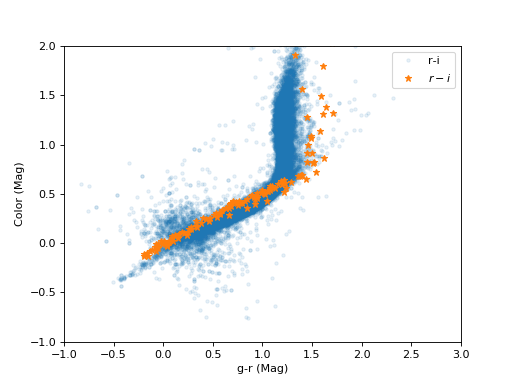

In [467]:
plt.figure()
#plt.plot(gr,kr,'.',alpha=0.2,label='$K-r$')
plt.plot(gr,ri,'.',alpha=0.1,label='r-i')
#plt.plot(gr,iz,'.',alpha=0.1,label='i-z')
#plt.plot(gr,zy,'.',alpha=0.1,label='z-y')

plt.plot(grs,synth['PS1_r']-synth['PS1_i'],'*',label='$r-i$')
#plt.plot(grs,synth['PS1_i']-synth['PS1_z'],'*',label='$i-z$')
#plt.plot(grs-.5,synth['PS1_z']-synth['PS1_y']+.5,'*',label='$z-y$')
#plt.plot(ris,synth['Kepler_k']-synth['PS1_g'],'*',label='$K-r$')
plt.ylim(-1,2)
plt.xlim(-1,3)
plt.ylabel('Color (Mag)')
plt.xlabel('g-r (Mag)')
plt.legend()
#plt.savefig('messy.png')

<IPython.core.display.Javascript object>


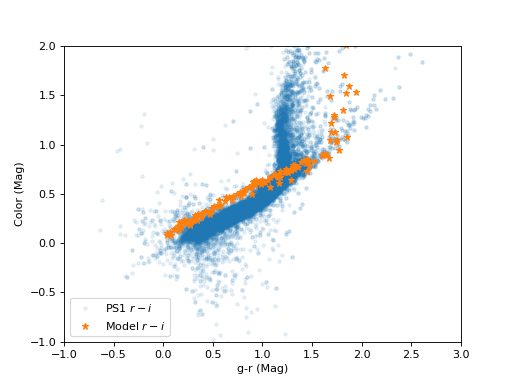

In [416]:
plt.figure()
#plt.plot(gr,kr,'.',alpha=0.2)
plt.plot(gr,ri,'.',alpha=0.1,label='PS1 $r-i$')
#plt.plot(gr,iz,'.',alpha=0.1,label='i-z')
#plt.plot(gr,zy,'.',alpha=0.1,label='z-y')

plt.plot(grs,synth['PS1_r']-synth['PS1_i'],'*',label='Model $r-i$')
#plt.plot(grs,synth['PS1_i']-synth['PS1_z'],'*',label='$i-z$')
#plt.plot(grs-.5,synth['PS1_z']-synth['PS1_y']+.5,'*',label='$z-y$')
#plt.plot(ris-.5,synth['Kepler_k']-synth['PS1_r'],'*',label='$K-r$')
plt.ylim(-1,2)
plt.xlim(-1,3)
plt.ylabel('Color (Mag)')
plt.xlabel('g-r (Mag)')
plt.legend()
#plt.savefig('ccplot.png')

In [299]:
len(ps1)

169425

In [301]:
ps1 = ps1.drop_duplicates()

In [263]:
wget = 'wget -q http://archive.stsci.edu/hlsps/everest/v2/c{Camp:02}/{first4}00000/{last5}/hlsp_everest_k2_llc_{EPIC}-c{Camp:02}_kepler_v2.0_lc.fits'

In [343]:
gets = []
for i in range(len(ps1)):
    ID = str(ps1['ID'].iloc[i])
    
    if ps1['campaign'].iloc[i] ==11:
        wget = 'wget -q http://archive.stsci.edu/hlsps/everest/v2/c{Camp:02}1/{first4}00000/{last5}/hlsp_everest_k2_llc_{EPIC}-c{Camp:02}1_kepler_v2.0_lc.fits'
        w = wget.format(Camp = ps1['campaign'].iloc[i], first4 = ID[:4], last5 = ID[-5:],EPIC = ID)
        gets += [w]
        wget = 'wget -q http://archive.stsci.edu/hlsps/everest/v2/c{Camp:02}2/{first4}00000/{last5}/hlsp_everest_k2_llc_{EPIC}-c{Camp:02}2_kepler_v2.0_lc.fits'
        w = wget.format(Camp = ps1['campaign'].iloc[i], first4 = ID[:4], last5 = ID[-5:],EPIC = ID)
        gets += [w]
    else:
        wget = 'wget -q http://archive.stsci.edu/hlsps/everest/v2/c{Camp:02}/{first4}00000/{last5}/hlsp_everest_k2_llc_{EPIC}-c{Camp:02}_kepler_v2.0_lc.fits'
        w = wget.format(Camp = ps1['campaign'].iloc[i], first4 = ID[:4], last5 = ID[-5:],EPIC = ID)
        gets += [w]

In [344]:
arr = np.array(gets)

In [345]:
np.savetxt('everest_downloads.sh',arr, fmt='%s')

In [275]:
a = str(ps1['ID'][0])

In [276]:
a[:4]I

'2402'

In [277]:
a[-5:]

'51695'

In [324]:
dow = np.loadtxt('/Users/ryanr/Desktop/downloaded.txt',dtype='str')

In [326]:
dow= dow[1:]

In [329]:
truth = np.zeros(len(arr)) * True

In [331]:
truth+ True

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
truth

In [357]:
ind = []
for i in range(len(test)):
    if (test[i] != dow).all():
        ind += [i]
    else:
        print('dow')

dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow


dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow


dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow
dow


In [360]:
np.savetxt('everest_downloads.sh',arr[ind], fmt='%s')

In [356]:
('hlsp_everest_k2_llc_213429430-c07_kepler_v2.0_lc.fits' == dow).any()

True